# scRNAseq downstream analysis

Prepared by: Krystian G. Komenda

### Downstream analysis - short documentation:
* Each codeblock is a separate script. To run downstream analysis, go to Module0 - Parameters.py, then specify your working base_path and make sure, that your base path contains folder with single cell data to process.
  
* If you do not want to specify your parameters, simply run main.py

#### Updates (01.28.2025):

Module0:
- Renamed filterCell_threshold to MTfilterCell_threshold

Module1:
- added new folder csv_tables, that is the output folder for: metadata, ranked_clusters,ranked_celltypes

Module9:
- Removed target_sum setting for normalization: default median count depth is used instead
- Removed the min_mean, max_mean, min_disp setting for the highly variable genes in the code
- Instead of removing, changed discarding highly variable genes as option (default is set to False)
- Added optional option of scaling the data (def. True, type=bool), added max_value parameter to None by default (type= float or None). By default is None, but must be specified by the user.

Module12:
- Removed n_neigbors value - default value is automatically used.
- Removed sc.tl.rank_genes_groups; moved them to Module13
  
Module13:
- Prepared K_top and m_bins documentation (see in module 13)
- Added K_top_param and m_bins_param as parameters to modify in Module0.
- This function calculates now tl.rank_genes for clusters (leiden) and for scoreCT (scoreCT). It also saves data in adata indivually to prevent data overwriting.

Module15:
- Modified adata as QC table that contain columns: n_cells, mt, mean_counts, pct_dropout_by_counts,total_counts,highly_variable, means, dispersions, dispersions_norm
- Added threshold of displaying table: qc_display_limit = 2000 (stored in Module0 (Parameters). If table exceed size of 2000 rows, it prints message of possibility to download QC table.
- Added option to download QC table in csv format
- Added option to download whole adata object (but it overlaps with the function from Module13).
- created interactive table with ranked genes per cluster: display first 10 rows by default and allows users to download full table (analogically like in previous modules).

Module16:
-created two main functions:
    - DE_options() that prints user all possible groups and factors to make comparison
    - DE_analysis() that generates all possible plots for DE analysis in a single sample


#### Module0: Parameters.py

In [202]:
#Input paths:
"""
Basic input paths, that specifies working directory 
and marker file location.
"""
base_path = r"C:\Users\kkomenda\Documents\scRNAseq\test"

#marker file is necessary to load link for table:
marker_file = 'https://raw.githubusercontent.com/nasa/GeneLab_Data_Processing/master/scRNAseq/10X_Chromium_3prime_Data/GeneLab_CellType_GeneMarkers/GL-DPPD-7111_GeneMarker_Info.csv'

In [319]:
"""
All user-adjustable parameters for metadata, filtering,
plot saving, plot adjusting, PCA calculating, regression,
clustering, Cell Type annotation.
"""
#Study metadata:
Species = "Mus musculus"
Tissue= "spleen"
#Basic Filtering parameters:
DEFAULT_GENES_PERCENTILE = 1

DEFAULT_CELLS_PERCENTILE = 5

#Parameters to plot Genes and Cells:
save_format = "png"
save_dpi = 300
genes_plot = True
cells_plot = True

#Parameters for Violin plots etc:
jitter_param = 0.4

#filter cells based on gene counts (basic is 2500):
filter_gene_counts = 2500

#number of pcs in PCA plot:
n_pcs=20

#Module8 - MTfilterCells:
MTfilterCell_threshold = 5

#resolution of leiden clustering:
cluster_resolution= 0.5 # by default: 0.5 means coarser clusters, 1.0 - finer clusters

#scoreCT parameters annotation:
K_top_param = 300
m_bins_param = 5

null_model_param='multinomial'
cluster_key_param='leiden'
clustering_method="wilcoxon"

#plotUMAP:
umap_color= "scoreCT"

#QC table limit for displaying:
qc_display_limit=2000

#Module16: comparing factors:
comparison_group = "5"
comparison_factor = "leiden"


#### Module1: Structure.py
- Generate folder structure: plots and AnnData results

In [216]:
import os

def Structure():
    """
    Generate folder structure: plots,AnnData and csv_tables in working directory.
    """
    # Define folder names
    folders = ['plots', 'AnnData', "csv_tables"]
    
    # Create the folders if they don't exist
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)
            print(f"Folder '{folder}' created.")
        else:
            print(f"Folder '{folder}' already exists.")

#### Module1.5: GetDirectories.py

In [234]:
import os
import gzip
import shutil

#load base directory path:
out = []

def GetDirectories(base_path=None):
    """
    Function for getting directories, checking if they are zipped properly and storing them in 
    out variable.

    Parameters:
    base_path: Working directory containing folders with samples inside.

    NOTE: It does not matter the structure of folders, it looks for "filtered" folder only!
    """
    
    required_files = {"barcodes.tsv.gz", "features.tsv.gz", "matrix.mtx.gz"}
    out = []  # Clear the global variable before running

    for root, dirs, files in os.walk(base_path):
        # Skip hidden directories
        dirs[:] = [d for d in dirs if not d.startswith('.')]

        # Check if the current path contains "filtered"
        if "filtered" in root.split(os.sep):
            out.append(root)

            # Check for existing .gz files
            existing_files = {f for f in files if f.endswith(".gz")}
            missing_files = required_files - existing_files  # Find missing required files

            # Zip missing files
            for missing in missing_files:
                original_file = missing.replace(".gz", "")
                original_path = os.path.join(root, original_file)

                if os.path.exists(original_path):  # Ensure the original file exists
                    with open(original_path, 'rb') as f_in:
                        with gzip.open(original_path + '.gz', 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    print(f"Zipped: {original_path} -> {original_path}.gz")
                else:
                    print(f"Missing file for zipping: {original_path}")

            # If all required files are present
            if not missing_files:
                print(f"All required .gz files are already present in: {root}")

    print("Filtered directories:", out)
    return out

#### Module2: GitLoad.py

In [21]:
import pandas as pd

GeneMarkers = None

def GitLoad(csv_url):
    """
    Function that searches GitHub table, based on defined Species and Tissue,
    downloads, process and saves it
    into scoreCT readible format.

    Parameters:
    GeneMarkers output file (in .gmt file format)
    """
    #set GeneMarkers globally - it is a path to formatted file
    global GeneMarkers
    
    # Load GitHub link
    df = pd.read_csv(csv_url)
    df = pd.DataFrame(df)
    
    # Filter DataFrame based on predefined Species and Tissues
    filtered_df = df[(df['Species'] == Species) & (df['Tissue'] == Tissue)]

    
    if not filtered_df.empty:
        link = filtered_df['Link'].values[0] #Catch link for matched filter
        name = filtered_df['Gene Marker File'].values[0] #Catch name for file
        name = name.replace(".csv", "") #clean filename
        GeneMarkers = name + ".gmt" #prepare file output name
        
    else:
        print("No matching rows found")
        return

    #Converting procedure from csv to gmt if it will not find proper gmt file:
    if not link.endswith(".gmt"):

        df_link = pd.read_csv(link)
        #set up names:
        column_name = 'cellName'
        column_gene = 'geneSymbol'

        #security:
        if column_name not in df_link.columns or column_gene not in df_link.columns:
            GeneMarkers = None
            return

        #split and select only columns that are needed:
        df_selected = df_link[[column_name, column_gene]]
        df_split = df_selected[column_gene].str.split(',', expand=True)
        df_result = pd.concat([df_selected[[column_name]], df_split], axis=1)
       
        #Add another column to avoid issues in reading gmt file
        df_result.insert(1, 'na_column', 'na')
        
        #save file:
        df_result.to_csv(GeneMarkers, sep='\t', header=False, index=False)

#### Module3: SaveData.py

In [309]:
import matplotlib.pyplot as plt  # Ensure this is imported
import os
def SaveData(adata=None, genes_plot=None, cells_plot=None, mt_analysis=False, 
             genes_counts=None, total_counts=None, pct_counts_mt=None, 
             pct_mt_scatter=None, genes_counts_scatter=None, postNormplot = None,
             PCAplot=None, scoreCT_out=None, umap=None, ClusterPlot=None, count_matrix=None, metadata=None,
             qc_table=None, save_cluster=None, save_celltype=None, save_DE_groups = None, save_DE_violin=None,
             save_DE_dotplot=None, save_DE_matrixplot=None, save_DE_stacked_violin=None, save_DE_heatmap=None
            ):
    """
    Function executes data saving from user defined preferences.
    By default, all parameters are empty and saving is not executed.

    By default, saving plot format is set to png and dpi is set to 300.
    It is possible to change parameters in parameters.py function.
    """
    # Create folders if they do not exist
    if not os.path.exists('AnnData'):
        os.makedirs('AnnData')
    
    if not os.path.exists('plots'):
        os.makedirs('plots')

    if not os.path.exists('csv_tables'):
        os.makedirs('csv_tables')
        
    if adata is not None:
        adata.write(f"AnnData/{sample_name}_filtered.h5ad")
        print(f"Filtered data saved to {sample_name}_filtered.h5ad")
    
    if genes_plot is not None:
        genes_plot.figure.savefig(f"plots/{sample_name}_genes_plot.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved genes_plot plot as {sample_name}_genes_plot.{save_format}")

    if cells_plot is not None:
        cells_plot.figure.savefig(f"plots/{sample_name}_cells_plot.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved cells_plot plot as {sample_name}_cells_plot.{save_format}")
        
    if genes_counts is not None:
        genes_counts.figure.savefig(f"plots/{sample_name}_violin_genes_counts.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved genes_counts plot as {sample_name}_violin_genes_counts.{save_format}")

    if total_counts is not None:
        total_counts.figure.savefig(f"plots/{sample_name}_violin_total_counts.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved total_counts plot as {sample_name}_violin_total_counts.{save_format}")

    if pct_counts_mt is not None:
        pct_counts_mt.figure.savefig(f"plots/{sample_name}_violin_pct_counts_mt.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved pct_counts_mt plot as {sample_name}_violin_pct_counts_mt.{save_format}")

    if pct_mt_scatter is not None:
        pct_mt_scatter.figure.savefig(f"plots/{sample_name}_scatter_pct_mt.{save_format}",  bbox_inches='tight' ,dpi=save_dpi)
        print(f"Saved pct_mt_scatter plot as {sample_name}_scatter_pct_mt.{save_format}")

    if genes_counts_scatter is not None:
        genes_counts_scatter.figure.savefig(f"plots/{sample_name}_scatter_genes_counts.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved genes_counts_scatter plot as {sample_name}_scatter_genes_counts.{save_format}")

    if postNormplot is not None:
        postNormplot.figure.savefig(f"plots/{sample_name}_HighlyExpressedGenes.{save_format}",  bbox_inches='tight' ,dpi=save_dpi)
        print(f"Saved HighlyExpressedGenes plot as {sample_name}_HighlyExpressedGenes.{save_format}")

    if PCAplot is not None:
        PCAplot.figure.savefig(f"plots/{sample_name}_PCAplot.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved PCAplot plot as {sample_name}_PCAplot.{save_format}")

    if scoreCT_out is not None:
        scoreCT_out.write(f"AnnData/{sample_name}_annotated.h5ad")
        print(f"Annotated data saved to {sample_name}_annotated.h5ad")

    if umap is not None:
        umap.figure.savefig(f"plots/{sample_name}_UMAP_{umap_color}.{save_format}", bbox_inches='tight', dpi=save_dpi)
        print(f"Saved UMAP plot as {sample_name}_UMAP_{umap_color}.{save_format}")

    if ClusterPlot is not None:
        ClusterPlot.savefig(f"plots/{sample_name}_ClusterPlot.{save_format}", bbox_inches='tight' ,  dpi=save_dpi)
        print(f"Saved ClusterPlot plot as {sample_name}_ClusterPlot.{save_format}")

    if count_matrix is not None:
        count_matrix.to_csv(f"csv_tables/count_matrix_{sample_name}.csv")
        print(f"Raw count matrix was saved to: count_matrix_{sample_name}.csv")

    if metadata is not None:
        metadata.to_csv(f"csv_tables/metadata_{sample_name}.csv")
        print(f"Metadata was saved to: metadata_{sample_name}.csv")
        
    if qc_table is not None:
        qc_table.to_csv(f"csv_tables/{sample_name}_qc_table.csv")
        print(f"QC table was saved to: {sample_name}_qc_table.csv")

    if save_celltype is not None:
        save_celltype.to_csv(f"csv_tables/{sample_name}_ranked_CellType.csv")
        print(f"Ranked genes cell type were saved to: {sample_name}_ranked_CellType.csv")

    if save_cluster is not None:
        save_cluster.to_csv(f"csv_tables/{sample_name}_ranked_Cluster.csv")
        print(f"Ranked Clusters were saved to:{sample_name}_ranked_Cluster.csv")

    if save_DE_groups is not None:
        save_DE_groups.savefig(f"plots/{sample_name}_DE_groups.{save_format}", bbox_inches='tight' ,  dpi=save_dpi)
        print(f"Saved rank genes groups to: {sample_name}_DE_groups.{save_format}")

    if save_DE_violin is not None:
        save_DE_violin.savefig(f"plots/{sample_name}_DE_violin.{save_format}", bbox_inches='tight' ,  dpi=save_dpi)
        print(f"Saved rank genes group violin to: {sample_name}_DE_violin.{save_format}")

    if save_DE_dotplot is not None:
        save_DE_dotplot.savefig(f"plots/{sample_name}_DE_dotplot.{save_format}", bbox_inches='tight' ,  dpi=save_dpi)
        print(f"Saved rank genes group dotplot to: {sample_name}_DE_dotplot.{save_format}")

    if save_DE_matrixplot is not None:
        save_DE_matrixplot.savefig(f"plots/{sample_name}_DE_matrixplot.{save_format}", bbox_inches='tight' ,  dpi=save_dpi)
        print(f"Saved rank genes group matrixplot to: {sample_name}_DE_matrixplot.{save_format}")

    if save_DE_stacked_violin is not None:
        save_DE_stacked_violin.savefig(f"plots/{sample_name}_DE_stacked_violin.{save_format}", bbox_inches='tight' ,  dpi=save_dpi)
        print(f"Saved rank genes group stacked violin to: {sample_name}_DE_stacked_violin.{save_format}")

    if save_DE_heatmap is not None:
        save_DE_heatmap.savefig(f"plots/{sample_name}_DE_heatmap.{save_format}", bbox_inches='tight' ,  dpi=save_dpi)
        print(f"Saved rank genes group heatmap to: {sample_name}_DE_heatmap.{save_format}")

#### Module4: BasicFiltering.py

In [320]:
import numpy as np
import scanpy as sc

def BasicFiltering(Organism=Species, genes_percentile=None, cells_percentile=None, save_data=False):

    """
    Performs basic filtering on scRNAseq data based on gene and cell percentiles.

    Parameters:
    - Organism (str): The species of the dataset. Default values are set for:
    a) "Drosophila melanogaster" (genes_percentile=5, cells_percentile=5)
    b) "Zebrafish" (genes_percentile=3, cells_percentile=5)
    c) Arabidopsis thaliana" (genes_percentile=1, cells_percentile=5)
    - genes_percentile (int, optional): The percentile threshold for gene filtering.
    - cells_percentile (int, optional): The percentile threshold for cell filtering.
    - save_data (optional): If True, saves the filtered AnnData object.

    Return:
    - adata (AnnData): The filtered AnnData object.

    Functionality:
    - calculates QC metrics and does filtering thresholds with percentiles.
    - Filters cells with fewer detected genes than the gene threshold.
    - Filters genes expressed in fewer cells than the cell threshold.
    """

    #Adding parameter organism and different parameters for the future:
    if Organism == "Drosophila melanogaster":
        
        # Set specific values for Drosophila
        genes_percentile = 5
        cells_percentile = 5
        
    elif Organism == "Zebrafish":
        
        # Set specific values for Zebrafish
        genes_percentile = 3
        cells_percentile = 5
        
    elif Organism == "Arabidopsis thaliana":
        
        # Set specific values for Arabidopsis thaliana
        genes_percentile = 1
        cells_percentile = 5

    # Calculate QC metrics
    stat = sc.pp.calculate_qc_metrics(adata, inplace=False)
    cdf = stat[0]
    gdf = stat[1]

    # Use user-specified percentiles or defaults
    genes_percentile = genes_percentile if genes_percentile is not None else DEFAULT_GENES_PERCENTILE
    cells_percentile = cells_percentile if cells_percentile is not None else DEFAULT_CELLS_PERCENTILE

    # Calculate thresholds
    genes = list(set(cdf['n_genes_by_counts']))
    cells = list(set(gdf['n_cells_by_counts']))

    gene_threshold = np.percentile(genes, genes_percentile)
    cell_threshold = np.percentile(cells, cells_percentile)


    # Save the thresholds in adata.uns
    adata.uns['gene_threshold'] = gene_threshold
    adata.uns['cell_threshold'] = cell_threshold

    #Perform filtering 
    sc.pp.filter_cells(adata, min_genes=gene_threshold)
    sc.pp.filter_genes(adata, min_cells=cell_threshold)

    print(f'Filter out cells expressing fewer than: {gene_threshold} genes ({genes_percentile}th percentile)')
    print(f'Filter out genes detected in fewer than: {cell_threshold} cells ({cells_percentile}th percentile)')

    # Save adata if requested
    if save_data:
        SaveData(adata=adata)
    return adata
    

#### Module5: plotCellsAndGenes.py
Plot 1 and 2: Distribution plot of genes vs cells and cells vs genes:

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

def plotCellsAndGenes(genes_plot=genes_plot, cells_plot=cells_plot, save_data=False):
    """
    Parameters:
    - genes_plot (bool): If True, plots the distribution of the number of genes detected per cell.
    - cells_plot (bool): If True, plots the distribution of the number of cells expressing each gene.
    - save_data (bool, optional): If True, saves the generated plots.

    Functionality:
    - QC metrics and filtering thresholds from the adata object.
    - Plots histograms of gene and cell distributions with red threshold lines.
    """
    # Calculate QC metrics based on the filtered adata from BasicFiltering
    stat = sc.pp.calculate_qc_metrics(adata, inplace=False)
    cell_qc_dataframe = stat[0]
    gene_qc_dataframe = stat[1]

    # Retrieve the filtering thresholds from the adata object after BasicFiltering
    gene_threshold = adata.uns.get('gene_threshold', None)
    cell_threshold = adata.uns.get('cell_threshold', None)
    
    if gene_threshold is None or cell_threshold is None:
        raise ValueError("Filtering thresholds not found in the adata object. Ensure BasicFiltering was run.")

    print(f'Gene threshold: {gene_threshold}')
    print(f'Cell threshold: {cell_threshold}')

    # Unique variables for plot data
    genes_plot_data = None
    cells_plot_data = None

    # Plot Number of Genes by Counts (only if genes_plot is True)
    if genes_plot:
        fig, ax = plt.subplots(figsize=(6, 4))  # Create a new figure for genes plot
        ax.hist(cell_qc_dataframe['n_genes_by_counts'], bins="sqrt")
        ax.set(xlabel='N genes', ylabel='N cells')
        ax.axvline(gene_threshold, color='red')
        ax.set_title("Number of genes by counts")
        #plt.show()
        genes_plot_data = fig  # Store figure for later use

    # Plot Number of Cells by Counts (only if cells_plot is True)
    if cells_plot:
        fig, ax = plt.subplots(figsize=(6, 4))  # Create a new figure for cells plot
        ax.hist([int(x) for x in gene_qc_dataframe['n_cells_by_counts'] if x != 0], bins="sqrt")
        ax.set(xlabel='N cells expressing > 0', ylabel='N genes')
        ax.axvline(cell_threshold, color='red')
        ax.set_title("Number of cells by counts")
        #plt.show()
        cells_plot_data = fig  # Store figure for later use
    
    if save_data:
        SaveData(genes_plot=genes_plot_data, cells_plot=cells_plot_data)
        print(f"Genes plot and Cells plot were saved!")
    

#### Module6: mtAnalysis.py

In [25]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mtAnalysis(analysis=True, save_mt=False):
    """
    Performs mtAnalysis.

    Parameters:
    - analysis (bool): If True, looks for mitochondrial genes and annotates them in the dataset.
    - save_mt (bool, optional): If True, saves the processed AnnData object.

    Functionality:
    - Identifies mitochondrial genes based on common prefixes and annotates them.
    - Calculates QC metrics, including the percentage of mitochondrial counts.
    """
    if analysis:
        
        # Check for common mitochondrial gene prefixes in the first 50 gene names
        mitochondrial_prefixes = ["MT-", "mt-", "M-", "m-", "mito-", "MITO-"]
        for prefix in mitochondrial_prefixes:
            mt_genes = [gene for gene in adata.var_names if gene.startswith(prefix)]
            if mt_genes:
                print(f'Prefix "{prefix}" found with {len(mt_genes)} mitochondrial genes:')
                print(mt_genes[:10])  # Print the first 10 mitochondrial genes found
                # Annotate mitochondrial genes as "mt"
                adata.var["mt"] = adata.var_names.str.startswith(prefix)
                break
            # Add flag to indicate mitochondrial analysis was performed
            adata.uns['mt_analysis'] = True
        
        else:
            print("No common mitochondrial gene prefix found in the first 50 gene names.")
            adata.var["mt"] = False  # No mitochondrial genes found

        # Calculate QC metrics including mitochondrial genes
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
        print(f"Annotated mitochondrial genes and calculated QC metrics.")
    else:
        # Perform QC metrics calculation without mitochondrial gene annotation
        sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
        print(f"Calculated QC metrics.")

    # Freeze current state for saving
    adata_frozen = adata.copy()

    # Save data if requested
    if save_mt:
        SaveData(adata=adata_frozen, mt_analysis=True)

    return adata

#### Module7: plotViolinScatter.py
- title does not work

In [26]:
import matplotlib.pyplot as plt
import scanpy as sc

def plotViolinScatter(genes_counts=True, total_counts=True, pct_counts_mt=True, pct_mt_scatter=True, genes_counts_scatter=True, save_data=False):
    """
    Generates and saves violin / scatter plots for QC metrics.

    Parameters:
    - genes_counts (bool): plots a violin plot - number of genes per cell
    - total_counts (bool): plots a violin plot - number of counts per cell
    - pct_counts_mt (bool): plots a violin plot - mitochondrial gene percentage.
    - pct_mt_scatter (bool): plots a scatter plot - total counts vs mitochondrial percentage
    - genes_counts_scatter (bool): plots a scatter plot - total counts vs number of genes.

    Functionality:
    - Uses scanpy to generate violin and scatter plots for dataset QC.
    """
    plots_data = {}

    # Collect generated plots for saving
    genes_counts_fig = None
    total_counts_fig = None
    pct_counts_mt_fig = None
    pct_mt_scatter_fig = None
    genes_counts_scatter_fig = None
    
    # Violin plots
    if genes_counts:
        genes_counts_fig = sc.pl.violin(adata, "n_genes_by_counts", jitter=jitter_param, show=False)

    
    if total_counts:
        total_counts_fig = sc.pl.violin(adata, "total_counts", jitter=jitter_param, show=False)
       
    if pct_counts_mt:
        if "pct_counts_mt" in adata.obs:
            pct_counts_mt_fig = sc.pl.violin(adata, "pct_counts_mt", jitter=jitter_param, show=False)
           
    # Scatter plots
    if pct_mt_scatter:
        pct_mt_scatter_fig = sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False)
       
    if genes_counts_scatter:
        genes_counts_scatter_fig = sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False)
        
    # Save data if requested
    if save_data:
       SaveData(
           genes_counts=genes_counts_fig,
           total_counts=total_counts_fig,
           pct_counts_mt=pct_counts_mt_fig,
           pct_mt_scatter=pct_mt_scatter_fig,
           genes_counts_scatter=genes_counts_scatter_fig
       )

#### Module8: MTFilterCells.py

In [27]:
import scanpy as sc

def FilterCells():

    """
    Filters cells based on gene counts and mitochondrial content
    if mitochondrial analysis has been performed.

    """
    
    global adata

    # Check if 'mt_analysis' exists in adata.uns and is True
    if 'mt_analysis' in adata.uns and adata.uns['mt_analysis'] == True:
        # Filter cells based on gene counts and mitochondrial content
        adata = adata[adata.obs.n_genes_by_counts < filter_gene_counts, :]
        adata = adata[adata.obs.pct_counts_mt < MTfilterCell_threshold, :].copy()  # Assuming you want to filter out cells with more than 5% mitochondrial genes
        print(f"Filtered cells based on gene counts with mt_analysis.")
    else:
        # Filter cells based only on gene counts
        adata = adata[adata.obs.n_genes_by_counts < filter_gene_counts, :]
        print(f"Filtered cells based on gene counts.")

#### Module9: Normalization.py & RegressOut.py

In [28]:
import numpy as np
import scanpy as sc

def Normalization(adata):
    """
    Normalize and preprocess the AnnData object.

    Returns:
    - Processed AnnData object.
    """
        # Freeze state:
    adata.raw = adata.copy()
    
    # Correct for library size:
    sc.pp.normalize_total(adata)

    # Perform log transformation:
    sc.pp.log1p(adata)

    # Identify highly variable genes:
    sc.pp.highly_variable_genes(adata)


    
    return adata

In [29]:
import numpy as np
import scanpy as sc

def RegressOut(adata, remove_h_genes = False, scaling=True, max_value=None):

    """
    RegressOut unwanted variables data, optionally remove highly variable genes and scale data.
    
    Parameters:
    - adata: AnnData object
    - remove_h_genes: boolean (def. False)
    - scaling: boolean (def. True) - optional to scale the data after regression
    - max_value: def. None. Best if won't exceed number of 10.
    
    Output:
    - adata: AnnData object
    """
    
    # Subset the data to include only highly variable genes (optional):
    if remove_h_genes:
        adata = adata[:, adata.var.highly_variable]

    # Check if mitochondrial analysis has been performed by checking adata.uns['mt_analysis']
    if 'mt_analysis' in adata.uns and adata.uns['mt_analysis'] == True:
        # Regress out total counts and mitochondrial gene percentages
        sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    else:
        # Only regress out total counts if mitochondrial analysis wasn't run
        sc.pp.regress_out(adata, "total_counts")

    # Scale the data
    if scaling:
        sc.pp.scale(adata, max_value=max_value)
    
    return adata

#### Module10: plotPostNormalization.py

In [30]:
import scanpy as sc
import matplotlib.pyplot as plt

def plotPostNormalization(save_data=False):
    
    global adata
    
    ax = sc.pl.highest_expr_genes(adata, n_top=20, show=False)
    
    # Set the title of the plot
    plt.suptitle(f"20 most highly expressed genes in sample: {sample_name}", fontsize=16)
    
    # If `save_data` is True, save the plot via SaveData function
    if save_data:
        postNormplot = ax.figure  # Store the plot figure
        SaveData(postNormplot=postNormplot)
    
    # Display the plot
    #plt.show()

#### Module11: plotPCA.py

In [31]:
import matplotlib.pyplot as plt
import scanpy as sc

def plotPCA(save_data=False):
    
    global adata

    #Calculate PCA:
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pl.pca_variance_ratio(adata, log=True, n_pcs = n_pcs, show=False)

    #title is not working...
    fig = plt.gcf()

    plt.suptitle(f"PCA Variance Ratio (Top {n_pcs} PCs in sample: {sample_name})", fontsize=16)
    fig.subplots_adjust(top=0.9)

    if save_data:
        plt.draw()
        SaveData(PCAplot=fig)
    
    
    #plt.show()

#### Module12: ClusterAnalysis.py

In [221]:
import scanpy as sc
import pandas as pd

def ClusterAnalysis():
    """
    Performs calculation of neighborhood graph using number of PCs,
    then embedds graph into 2 dimentions with UMAP, and performs
    clustering based on selected algorithm (leiden clustering
    with specified cluster resolution).
    """
    global adata
    #compute neighbor graph
    sc.pp.neighbors(adata, n_pcs=n_pcs)
    
    #Embed graph into 2 dimensions using UMAP:
    sc.tl.umap(adata)
    
    #perfom leiden clustering:
    sc.tl.leiden(adata, resolution= cluster_resolution)

#### Module 12.5: ClusterPlot.py

In [220]:
import matplotlib.pyplot as plt

def ClusterPlot(save_data=False):

   # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))  # Adjust size if needed
    
    # Generate the UMAP plot on the provided axis
    sc.pl.umap(
        adata,
        color=[cluster_key_param],
        use_raw=False,
        ax=ax,
        show=False,  # Prevent immediate display
        legend_loc="on data")
    
    # Set the title explicitly (modify if needed)
    ax.set_title(f"{cluster_key_param} clusters: {sample_name}", fontsize=16)

    # Save the figure if requested
    if save_data:
        SaveData(ClusterPlot=fig)  # Save the entire figure, including legend and title

    plt.show()  # Display the plot

#### Module13: ScoreCTAnnotation.py

In [150]:
#annotate with scoreCT:
import scanpy as sc
import pandas as pd
import scorect as ct
"""
Parameters:
- adata: AnnData object,
- marker_path: matrix table,
- K_top: parameter to tune sensitivity vs specifity,
    a) Increasing K_top generally increases the overall scores across cell types
    b) higher K_top can reduce variance between cell type scores - more genes are averaged into the score
    c) annotated cell types might shight if top-ranked genes weren't enough in smaller K_top values.
    d) default K_top = 300 is set for more robust work that would handle both simple and complex datasets

- m_bins: control the granularity of normalization
    a) the higher m_bins the lower range of scores - more "smooth" normalized highly expressed genes.
    b) cell types with strongly expressed genes may have reduced dominance in their scores.
    c) default m_bins= 10 (between 5-10) is set for balanced datasets or big variance of marker expressions.
    If clusters are well-separated it is possible to lower down to m_bins=3

- null_model:
- cluster key: 
"""
def ScoreCTAnnotation(save_data=False):
    scoreCT_out = ct.scorect(adata,
               marker_path= GeneMarkers, 
               K_top=K_top_param,
               m_bins=m_bins_param,
               null_model=null_model_param,
               cluster_key=cluster_key_param)

    # Rank genes for clusters (leiden groups)
    """
    Save the results individually to avoid overwriting.
    """
    sc.tl.rank_genes_groups(adata, groupby=cluster_key_param, use_raw=False, method=clustering_method)
    adata.uns["rank_genes_groups_leiden"] = adata.uns["rank_genes_groups"].copy()

    # Rank genes for cell types
    sc.tl.rank_genes_groups(adata, groupby="scoreCT", use_raw=False, method=clustering_method)
    adata.uns["rank_genes_groups_scoreCT"] = adata.uns["rank_genes_groups"].copy()
    if save_data:
        SaveData(scoreCT_out=adata)

#### Module14: PlotUMAP.py

In [35]:
import scanpy as sc
import matplotlib.pyplot as plt


def PlotUMAP(color=None, save_data=False):
    global adata, umap_color

    # use provided color if specified, default is "scoreCT":
    plot_color = color if color is not None else umap_color

    # Generate the UMAP plot
    sc.pl.umap(adata, color=[plot_color], title=[f"{sample_name}: {plot_color}"], use_raw=False, wspace=0.33, show=False)

    # Save umap:
    umap = plt.gcf()
    if save_data:
        SaveData(umap=umap)
    # plt.show()


#### Module 15: InteractiveTable.py


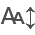

In [206]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from itables import show
import itables.options as opt
import pandas as pd
import os

# Function to download data
from IPython.display import FileLink

global adata

def InteractiveTable(save_data=False, save_adata=False, save_cluster=False, save_celltype=False):
    """
    Displays a table interactively and provides options to download the QC table and adata object.

    Parameters:
    - adata: AnnData object containing gene expression data.
    - output_dir: Directory where files will be saved for download.
    """
    # Configure itables options
    opt.maxRows = 10  # Show only 10 rows initially
    opt.maxBytes =  0  # No limit on data size
    opt.maxColumns = 0  # Display all columns

    # Define the QC metrics table
    if "n_cells" in adata.var.columns:
        qc_table = adata.var[
            [
                "n_cells",  # Number of cells expressing the gene
                "mt",  # If the gene is mitochondrial
                "mean_counts",  # Average counts in all cells
                "pct_dropout_by_counts",  # Percentage of cells with zero counts
                "total_counts",  # Total counts of the gene across all cells
                "highly_variable",  # the highly variable genes
                "means",  # Mean expression across cells
                "dispersions",  # Dispersion of expression
                "dispersions_norm",  # Normalized dispersion
            ]
        ]

        # Display QC table

        if len(qc_table) <= qc_display_limit:  # We can modify this threshold later
            display(qc_table.head(qc_display_limit))
        else:
            print(f"The QC table is too large to display, but it can be saved.")
        
        # Ranked genes per cluster
        if "rank_genes_groups_leiden" in adata.uns:
            ranked_genes = adata.uns["rank_genes_groups_leiden"]

            # Collect rows in a list of dictionaries
            ranked_table_rows = []
            for cluster in ranked_genes['names'].dtype.names:
                for i, gene in enumerate(ranked_genes['names'][cluster]):
                    ranked_table_rows.append({
                        "Cluster": cluster,
                        "Gene": gene,
                        "LogFC": ranked_genes['logfoldchanges'][cluster][i],
                        "P-Value (adj)": ranked_genes['pvals_adj'][cluster][i],
                    })

            # Convert the list of rows to a DataFrame
            ranked_table = pd.DataFrame(ranked_table_rows)

            print(f"Ranked genes per cluster:")
            display(ranked_table)

         # Ranked genes per cluster
        if "rank_genes_groups_scoreCT" in adata.uns:
            ranked_genes_scoreCT = adata.uns["rank_genes_groups_scoreCT"]

            # Collect rows in a list of dictionaries
            ranked_table_rows_scoreCT = []
            for cell_type in ranked_genes_scoreCT['names'].dtype.names:
                for i, gene in enumerate(ranked_genes_scoreCT['names'][cell_type]):
                    ranked_table_rows_scoreCT.append({
                        "CellType": cell_type,
                        "Gene": gene,
                        "LogFC": ranked_genes_scoreCT['logfoldchanges'][cell_type][i],
                        "P-Value (adj)": ranked_genes_scoreCT['pvals_adj'][cell_type][i],
                    })
                    
            ranked_table_scoreCT = pd.DataFrame(ranked_table_rows_scoreCT)
            
            print(f"Ranked genes per CellType:")
            display(ranked_table_scoreCT)
        else:
            print("Ranked genes per cluster are not available.")

        # Save QC table in csv format
        if save_data:
            SaveData(qc_table=qc_table)

        if save_adata:
            SaveData(adata=adata)

        if save_cluster:
            SaveData(save_cluster=ranked_table)

        if save_celltype:
             SaveData(save_celltype=ranked_table_scoreCT)
    else:
        print("The adata.var table does not contain enough QC metrics columns.")


#### Module16: DGE_Analysis.py

To perform complete DGE analysis, it is necessary to break down task for 2 options:

Option 1 - DGE for single sample

Option 2 - DGE for multiple samples
- retrieving metadata table is requiered to compare different conditions
- raw count matrix table is optional

##### Step1 (optional): Retrieve raw count table:

**NOTE: Don't run if you don't have to!**

This step is very optional only to retrieve raw count data that may be used in other DGE tools like DESeq2, Limma, Seurat etc.

In [241]:
import scanpy as sc
import pandas as pd
import numpy as np

def ExtractDE(save_data=False):
    
    # Extract raw count matrix
    count_matrix = pd.DataFrame(
        adata.raw.X.toarray() if not isinstance(adata.raw.X, np.ndarray) else adata.raw.X,
        index=adata.obs_names,  # Cells as rows
        columns=adata.raw.var_names  # Genes as columns
    )

    count_matrix = count_matrix.T

    if save_data:
        # Save the count matrix to a CSV file
        SaveData(count_matrix=count_matrix)
        
        #count_matrix.to_csv(f"raw_count_matrix.csv")


In [240]:
ExtractDE(save_data=True)

Raw count matrix was saved to: count_matrix_RRRM2_SPL_FLT_LAR_OLD_FO4_Gene.csv


##### Step2 (optional): Retrieve metadata table (for multiple sample comparison ):

**NOTE: Don't run if you don't have to!**

This step is important to perform DGE across different samples.

It has future potential to be expanded.

In [293]:
import re
import scanpy as sc
import pandas as pd


def ExtractMetadata(save_data=False, comparing_factor=None):
    """
    Extract metadata for future DGE comparison.
    """
    # This data is not raw, because we want to catch annotated clusters for cells
    # Every cell is represented by a label from a barcode
    metadata = adata.obs[[comparing_factor]]

    # Add original sample_name column
    metadata["sample_name"] = sample_name

    # Split the sample_name using the '_' separator
    split_name = sample_name.split("_")

    # Initialize metadata fields
    Tissue_type = None
    Age = None
    Conditions = None

    # Process the split parts of the sample_name
    if "BM" in split_name:
        Tissue_type = "Bone_marrow"
    elif "PBMC" in split_name:
        Tissue_type = "PBMC"
    elif "SPL" in split_name:
        Tissue_type = "Spleen"
        
    if "YNG" in split_name:
        Age = "young"
    elif "OLD" in split_name:
        Age = "old"
    if "GC" in split_name:
        Conditions = "Ground_control"
    elif "FLT" in split_name:
        Conditions = "Flight"


    # Add the derived metadata to the DataFrame
    metadata["Tissue_type"] = Tissue_type
    metadata["Age"] = Age
    metadata["Conditions"] = Conditions

    # Save the metadata to a CSV file if requested
    if save_data:
        SaveData(metadata=metadata)
        
    DE_metadata = metadata
    return metadata 

In [294]:
ExtractMetadata(save_data=True, comparing_factor="leiden")

Metadata was saved to: metadata_RRRM2_SPL_FLT_LAR_OLD_FO4_Gene.csv


C:\Users\kkomenda\AppData\Local\Temp\1\ipykernel_4008\1166248000.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["sample_name"] = sample_name
C:\Users\kkomenda\AppData\Local\Temp\1\ipykernel_4008\1166248000.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["Tissue_type"] = Tissue_type
C:\Users\kkomenda\AppData\Local\Temp\1\ipykernel_4008\1166248000.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

leiden                     sample_name Tissue_type  Age  \
AAACCCAAGACCATTC      5  RRRM2_SPL_FLT_LAR_OLD_FO4_Gene      Spleen  old   
AAACCCAAGGCAGCTA      8  RRRM2_SPL_FLT_LAR_OLD_FO4_Gene      Spleen  old   
AAACCCAAGGTGGGTT      5  RRRM2_SPL_FLT_LAR_OLD_FO4_Gene      Spleen  old   
AAACCCACAACCAATC      4  RRRM2_SPL_FLT_LAR_OLD_FO4_Gene      Spleen  old   
AAACCCACAAGTGCTT     11  RRRM2_SPL_FLT_LAR_OLD_FO4_Gene      Spleen  old   
...                 ...                             ...         ...  ...   
TTTGGTTTCCGCTAGG      4  RRRM2_SPL_FLT_LAR_OLD_FO4_Gene      Spleen  old   
TTTGTTGAGGGTAATT      3  RRRM2_SPL_FLT_LAR_OLD_FO4_Gene      Spleen  old   
TTTGTTGAGGTCGCCT      1  RRRM2_SPL_FLT_LAR_OLD_FO4_Gene      Spleen  old   
TTTGTTGAGTATAACG      5  RRRM2_SPL_FLT_LAR_OLD_FO4_Gene      Spleen  old   
TTTGTTGGTCACTAGT      0  RRRM2_SPL_FLT_LAR_OLD_FO4_Gene      Spleen  old   

                 Conditions  
AAACCCAAGACCATTC     Flight  
AAACCCAAGGCAGCTA     Flight  
AAACCCAAGGTGGGTT     Flight  
AAACCCACAACCAATC     Flight  
AAACCCACAAGTGCTT     Flight  
...                     ...  
TTTGGTTTCCGCTAGG     Flight  
TTTGTTGAGGGTAATT     Flight  
TTTGTTGAGGTCGCCT     Flight  
TTTGTTGAGTATAACG     Flight  
TTTGTTGGTCACTAGT     Flight  

[5097 rows x 5 columns]

##### Step3 (mandatory): Single sample DGE:

In [317]:
import scanpy as sc

def DE_options():
    """
    Print available groups for differential expression analysis.
    """
    print("Available factors:")
    for factor in ["leiden", "scoreCT"]:
        if f"rank_genes_groups_{factor}" in adata.uns:
            print(f"- {factor}: {list(adata.obs[factor].unique())}")

def DE_analysis(comparison_group=None, comparison_factor=None, save_data=False):
    """
    Perform differential expression analysis based on user input and generate all available DE plots.
    """
    if comparison_factor not in ["leiden", "scoreCT"]:
        print("Error: Choose 'leiden' or 'scoreCT'.")
        return
    
    if comparison_group not in adata.obs[comparison_factor].unique():
        print(f"Available groups for {comparison_factor} are: {list(adata.obs[comparison_factor].unique())}")
        return
    
    # plots:
    print("Generating DE plots...")
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key=f"rank_genes_groups_{comparison_factor}", show=False)
    save_DE_groups = plt.gcf()

    sc.pl.rank_genes_groups_violin(adata, groups=[comparison_group], n_genes=10, key=f"rank_genes_groups_{comparison_factor}", show=False)
    save_DE_violin = plt.gcf()

    sc.pl.rank_genes_groups_dotplot(adata, groups=[comparison_group], n_genes=10, key=f"rank_genes_groups_{comparison_factor}", show=False)
    save_DE_dotplot = plt.gcf()

    sc.pl.rank_genes_groups_matrixplot(adata, groups=[comparison_group], n_genes=10, key=f"rank_genes_groups_{comparison_factor}", show=False)
    save_DE_matrixplot = plt.gcf()

    sc.pl.rank_genes_groups_stacked_violin(adata, groups=[comparison_group], n_genes=10, key=f"rank_genes_groups_{comparison_factor}", show=False)
    save_DE_stacked_violin = plt.gcf()

    sc.pl.rank_genes_groups_heatmap(adata, groups=[comparison_group], n_genes=10, key=f"rank_genes_groups_{comparison_factor}", show=False)
    save_DE_heatmap = plt.gcf()
    
    
    if save_data:
        SaveData(
            save_DE_groups=save_DE_groups,
            save_DE_violin=save_DE_violin,
            save_DE_dotplot=save_DE_dotplot,
            save_DE_matrixplot=save_DE_matrixplot,
            save_DE_stacked_violin=save_DE_stacked_violin,
            save_DE_heatmap=save_DE_heatmap
        )
        
    print("DE analysis and plotting completed.")

##### Step4 (optional): Verify sparsity of sample:

**NOTE: Don't run if you don't have to!**

This step is optional to verify the sparsity of dataset and select the best tool for DGE analysis - in case if scanpy DGE won't be sufficient.

If dataset has more than 50% of zero elements it is considered as sparse. Please do not confuse with filtering stage! 
This step checks in how many total cell counts specific gene is expressed (such as gene Exo1, which can be expressed in 173 cells out of 10 000 in total (incl. all celltypes)).

In [8]:
import pandas as pd
import numpy as np
#load data (hardcoded!):

data= pd.read_csv(r"C:\Users\kkomenda\Documents\scRNAseq\test\DGE_plots_test\count_matrix_RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene.csv", index_col=0)
data2= pd.read_csv(r"C:\Users\kkomenda\Documents\scRNAseq\test\DGE_plots_test\count_matrix_RRRM2_Femur_BM_GC_LAR_OLD_GO19_Gene.csv", index_col=0)

In [5]:
total_elements = data.size
zero_elements = (data==0).sum().sum()
sparsity = zero_elements/total_elements

print(f"Sparsity of the dataset is: {sparsity: 0.2%}")

Sparsity of the dataset is:  91.57%


### Execute __main__.py

Folder 'plots' already exists.
Folder 'AnnData' already exists.
Folder 'csv_tables' already exists.
All required .gz files are already present in: C:\Users\kkomenda\Documents\scRNAseq\test\RRRM2_SPL_FLT_LAR_OLD_FO4_Gene\filtered
Filtered directories: ['C:\\Users\\kkomenda\\Documents\\scRNAseq\\test\\RRRM2_SPL_FLT_LAR_OLD_FO4_Gene\\filtered']
Processing directory: C:\Users\kkomenda\Documents\scRNAseq\test\RRRM2_SPL_FLT_LAR_OLD_FO4_Gene\filtered
Filter out cells expressing fewer than: 113.96000000000001 genes (1th percentile)
Filter out genes detected in fewer than: 87.0 cells (5th percentile)
Gene threshold: 113.96000000000001
Cell threshold: 87.0
Saved genes_plot plot as RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_genes_plot.png
Saved cells_plot plot as RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_cells_plot.png
Genes plot and Cells plot were saved!
Prefix "mt-" found with 14 mitochondrial genes:
['mt-Rnr1', 'mt-Rnr2', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd4l']
Annotated m

C:\Users\kkomenda\AppData\Local\anaconda3\envs\single-cell\Lib\site-packages\scanpy\preprocessing\_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved HighlyExpressedGenes plot as RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_HighlyExpressedGenes.png
Saved PCAplot plot as RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_PCAplot.png
Saved ClusterPlot plot as RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_ClusterPlot.png


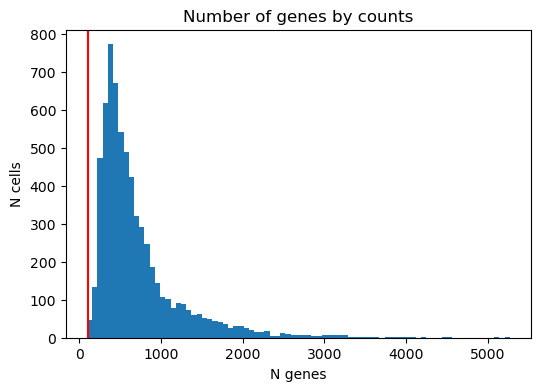

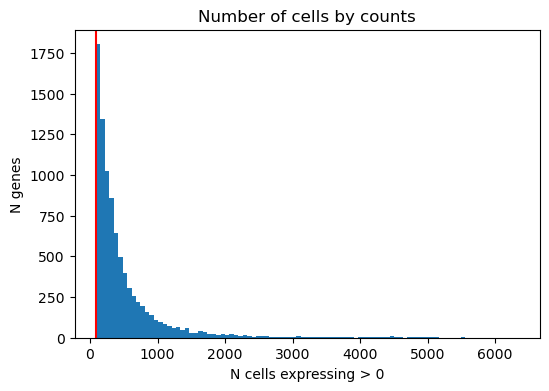

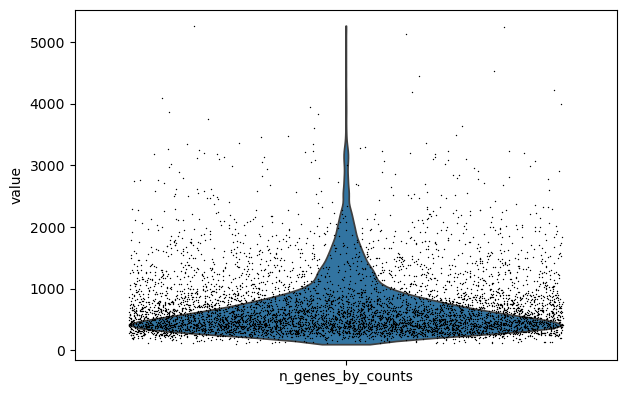

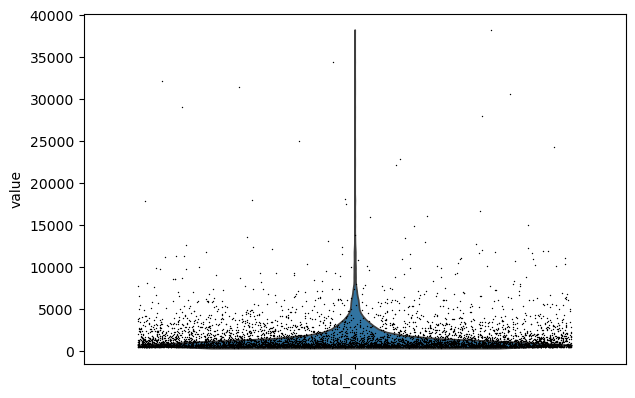

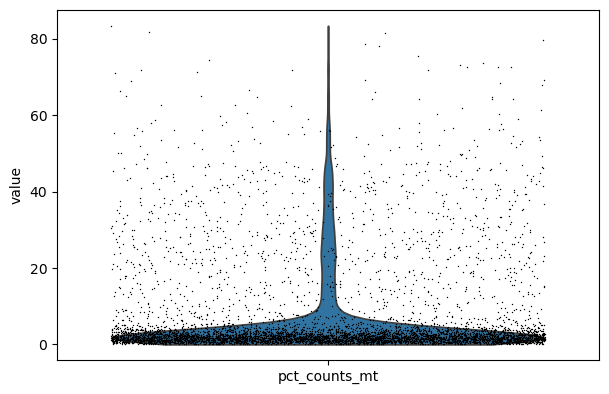

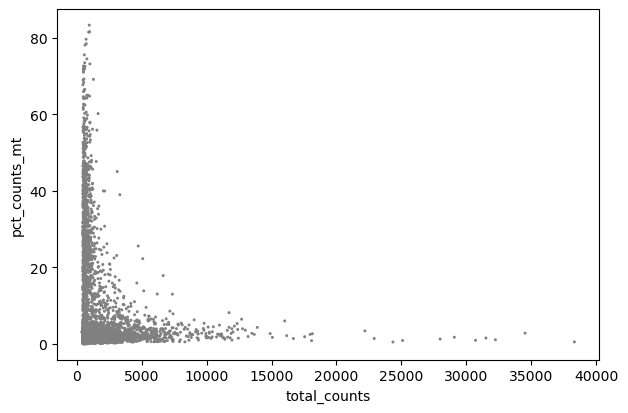

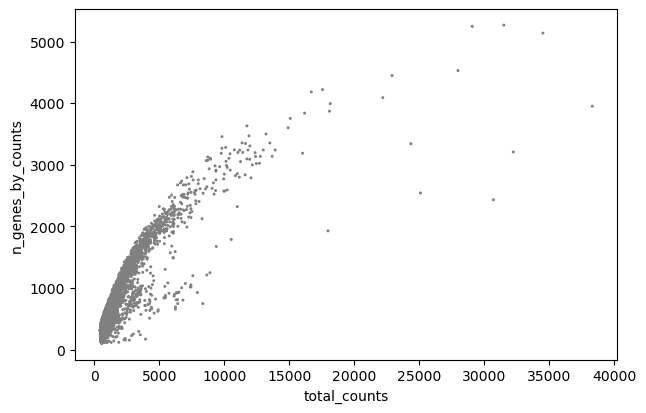

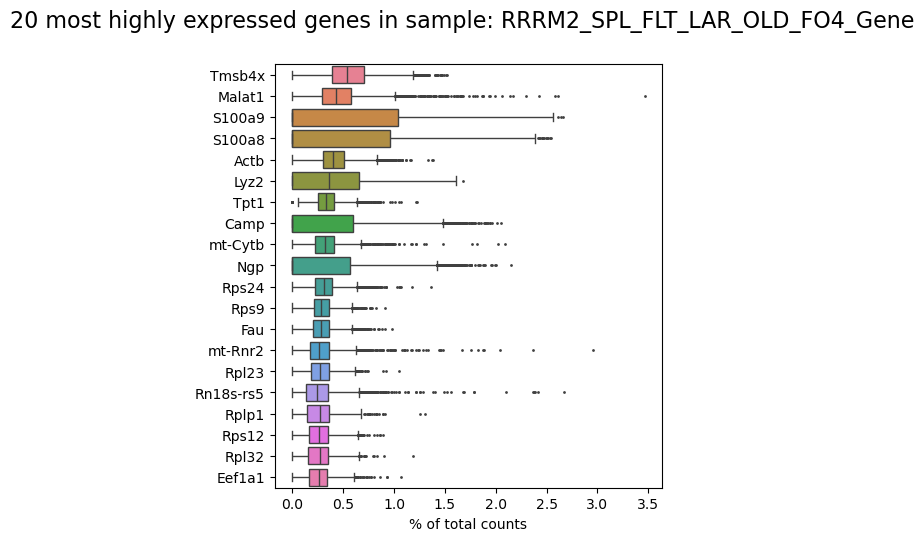

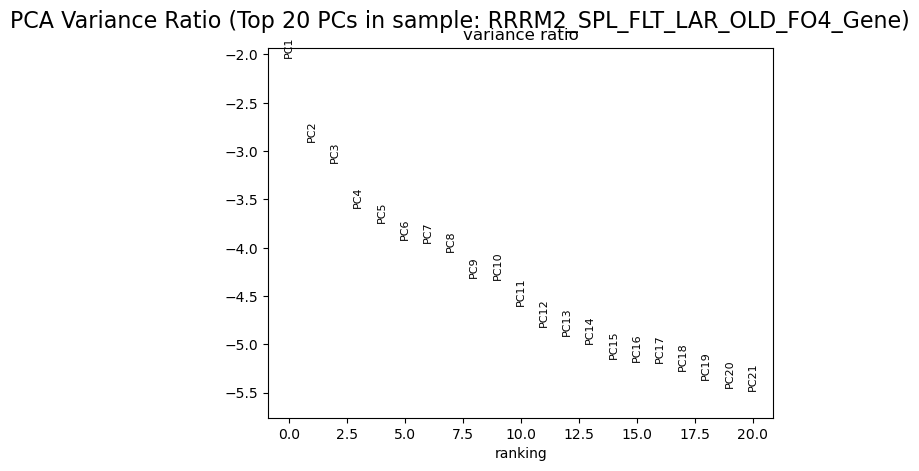

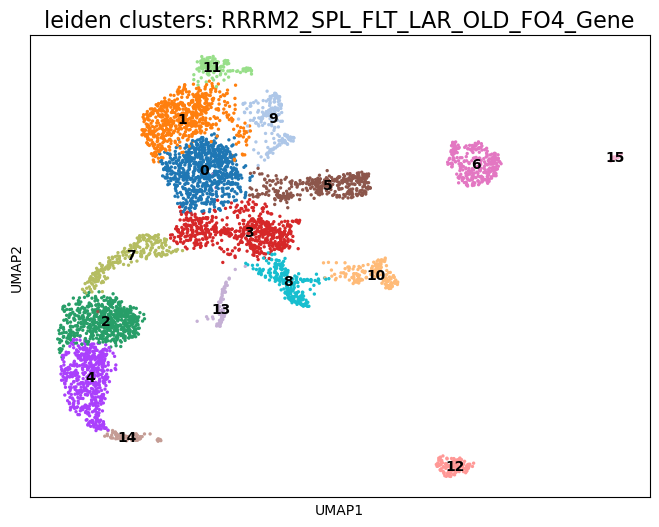

No differential test found in input AnnData object. Running Scanpy rank_gene_groups...
Using default values for differential test


C:\Users\kkomenda\AppData\Local\anaconda3\envs\single-cell\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:452: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
C:\Users\kkomenda\AppData\Local\anaconda3\envs\single-cell\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:452: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


Reading markers...
Wrangling: Number of markers used in ranked_gene_groups:  8977
Wrangling: Groups used for ranking: leiden
Scoring cell types in reference...
Assigning cell types in adata.obs['scoreCT']...


C:\Users\kkomenda\AppData\Local\anaconda3\envs\single-cell\Lib\site-packages\scorect\scorect_api.py:264: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clust_to_ct[cluster] = ct_score_df.loc[cluster][min_idx].idxmax()
C:\Users\kkomenda\AppData\Local\anaconda3\envs\single-cell\Lib\site-packages\scorect\scorect_api.py:264: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clust_to_ct[cluster] = ct_score_df.loc[cluster][min_idx].idxmax()
C:\Users\kkomenda\AppData\Local\anaconda3\envs\single-cell\Lib\site-packages\scorect\scorect_api.py:264: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a futu

Saved UMAP plot as RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_UMAP_scoreCT.png
The QC table is too large to display, but it can be saved.
Ranked genes per cluster:


Cluster    Gene     LogFC  P-Value (adj)
0            0   Crip1  2.810576  7.798900e-258
1            0  Tmsb10  2.000928  1.501912e-169
2            0   F13a1  2.826595  4.399227e-169
3            0   Ly6c2  1.943318  1.544795e-166
4            0    Psap  1.891030  4.366971e-147
...        ...     ...       ...            ...
143627      15   H2az1 -4.343864   3.170626e-08
143628      15   H3f3a -3.870600   7.668617e-10
143629      15   Actg1 -5.674068   3.745001e-12
143630      15    Actb -3.497428   7.996740e-15
143631      15  Tmsb4x -4.961596   6.377246e-16

[143632 rows x 4 columns]

Ranked genes per CellType:


CellType    Gene     LogFC  P-Value (adj)
0      B cell (immature markers noted*)    Apoe  5.066772   2.665961e-55
1      B cell (immature markers noted*)   H2-D1  2.026194   7.174113e-45
2      B cell (immature markers noted*)   Gngt2  4.923186   4.977250e-41
3      B cell (immature markers noted*)    Cst3  2.256733   4.977250e-41
4      B cell (immature markers noted*)     B2m  1.784305   6.454025e-41
...                                 ...     ...       ...            ...
89765              T cell (All markers)  Ifitm3 -4.750716   1.052194e-40
89766              T cell (All markers)   Plac8 -3.520106   3.866047e-45
89767              T cell (All markers)    Cybb -5.260048   6.230005e-49
89768              T cell (All markers)    Lyz2 -5.598247   1.289004e-70
89769              T cell (All markers)    Gpx1 -3.618451   5.432420e-74

[89770 rows x 4 columns]

QC table was saved to: RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_qc_table.csv
Filtered data saved to RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_filtered.h5ad
Ranked Clusters were saved to:RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_ranked_Cluster.csv
Ranked genes cell type were saved to: RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_ranked_CellType.csv
Finished processing RRRM2_SPL_FLT_LAR_OLD_FO4_Gene

Available factors:
- leiden: ['5', '8', '4', '11', '0', '10', '3', '1', '6', '2', '14', '12', '9', '13', '15', '7']
- scoreCT: ['Erythroid progenitor', 'NA', 'Neutrophil (All markers)', 'B cell (immature markers noted*)', 'Monocyte', 'Lymphocyte (All markers)', 'Macrophage Resident (white and red pulp)', 'T cell (All markers)', 'Natural killer T (NKT) cell', 'Plasma cell (mature B cell)']
Generating DE plots...
categories: 0, 1, 2, etc.
var_group_labels: 0


C:\Users\kkomenda\AppData\Local\anaconda3\envs\single-cell\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


categories: 0, 1, 2, etc.
var_group_labels: 0
categories: 0, 1, 2, etc.
var_group_labels: 0
categories: 0, 1, 2, etc.
var_group_labels: 0
Saved rank genes groups to: RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_DE_groups.png
Saved rank genes group violin to: RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_DE_violin.png
Saved rank genes group dotplot to: RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_DE_dotplot.png
Saved rank genes group matrixplot to: RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_DE_matrixplot.png
Saved rank genes group stacked violin to: RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_DE_stacked_violin.png
Saved rank genes group heatmap to: RRRM2_SPL_FLT_LAR_OLD_FO4_Gene_DE_heatmap.png
DE analysis and plotting completed.


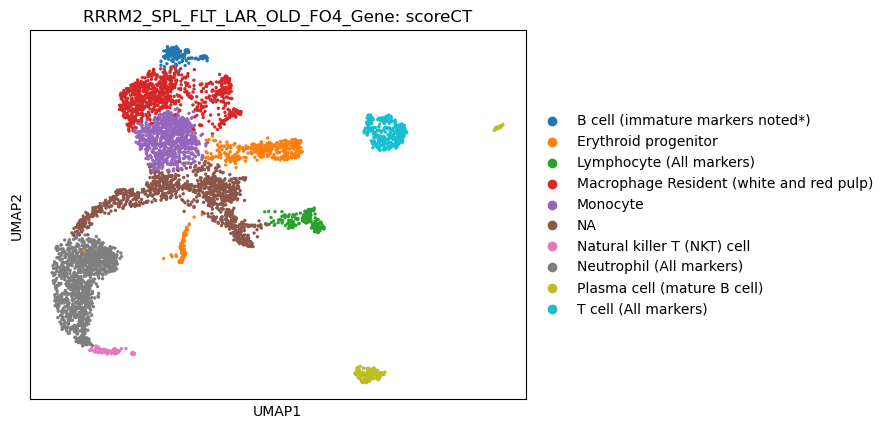

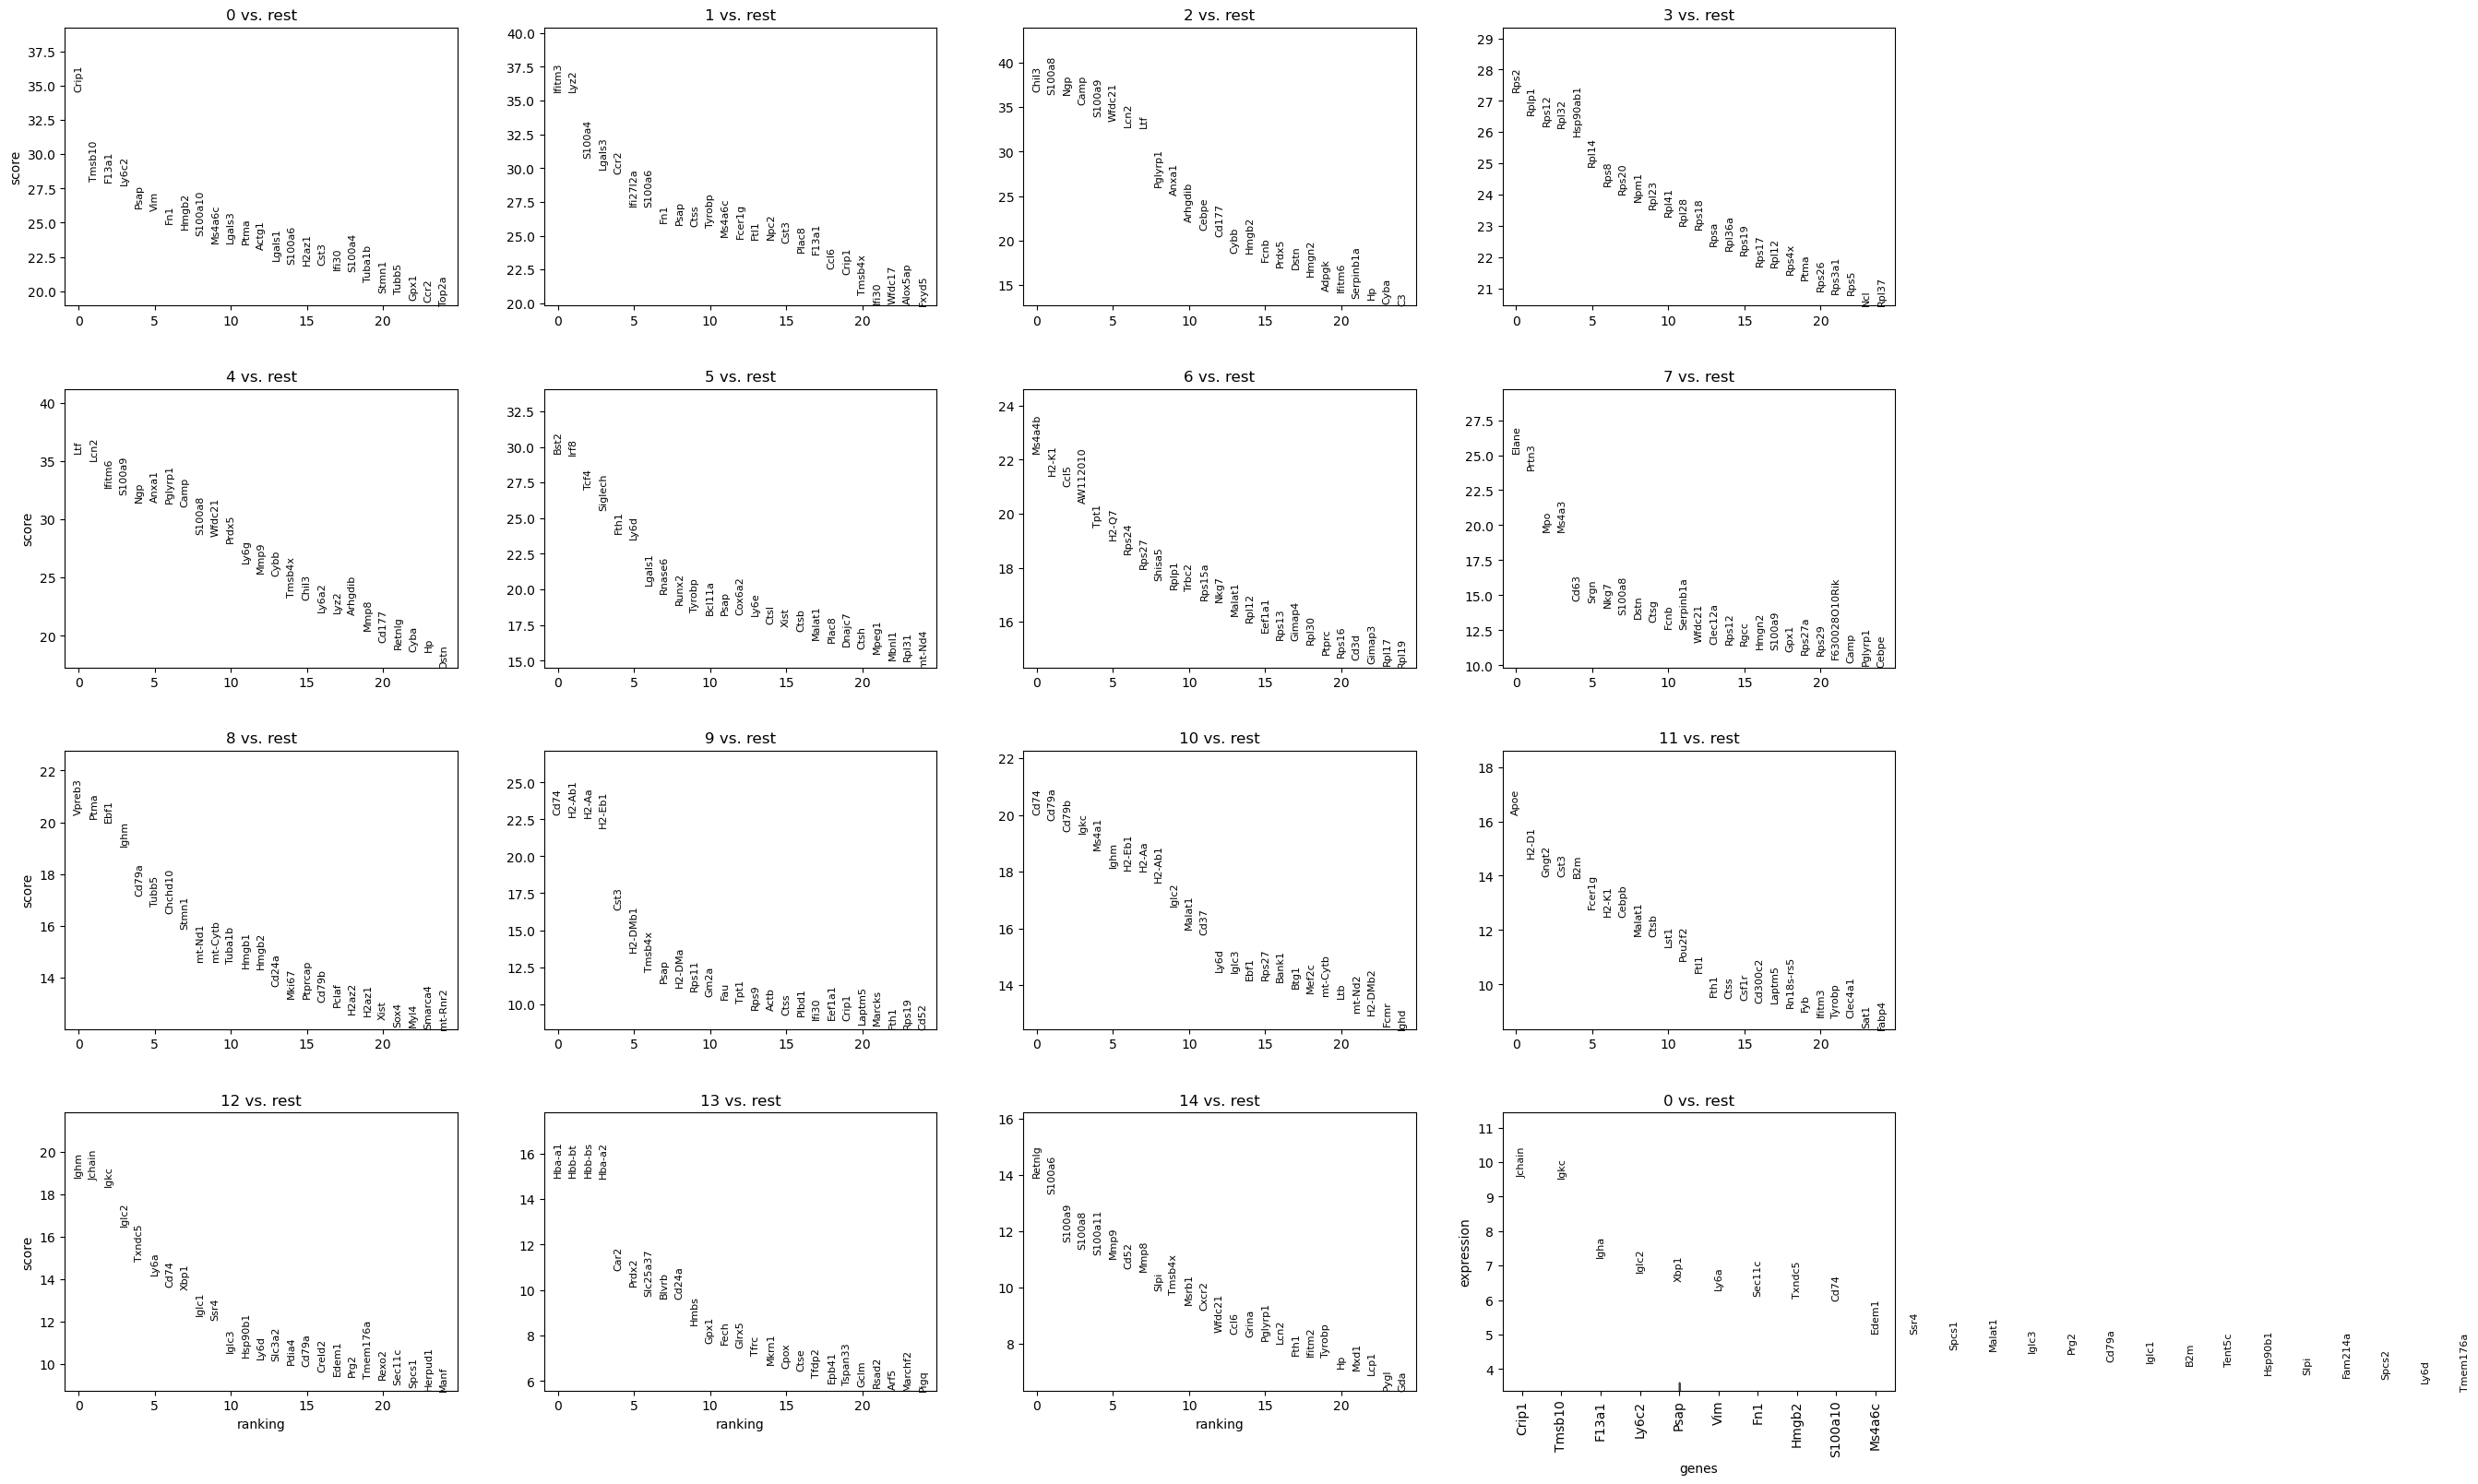

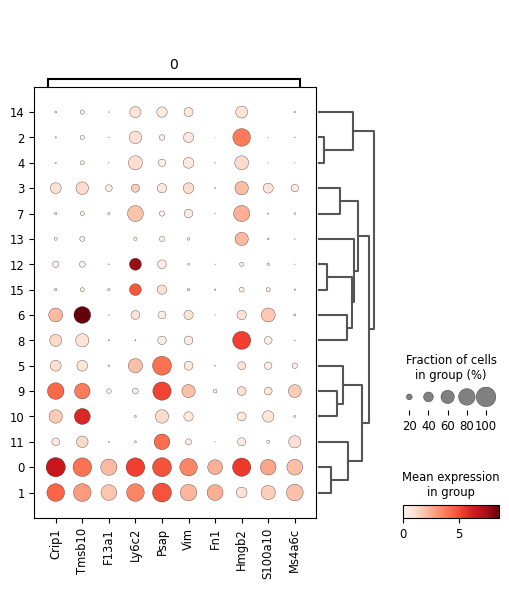

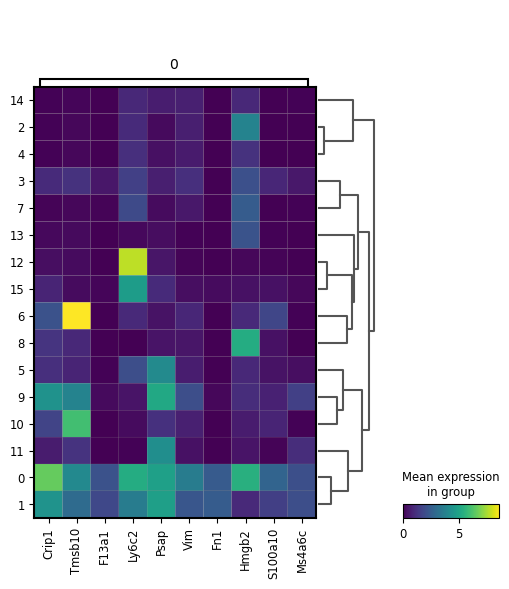

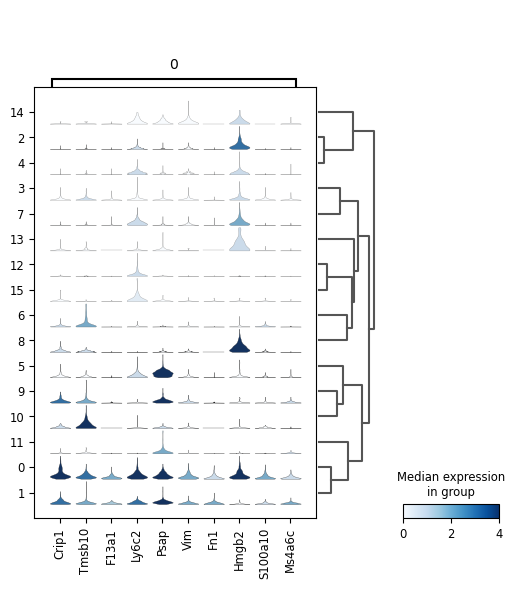

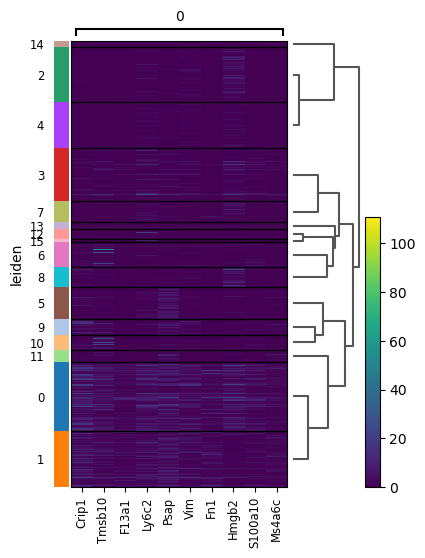

In [321]:
import os
import scanpy as sc

'''This script uses a loop to find all subdirectories
of working directory that contain scRNAseq datasets.
'''

#change working directory to base_path:
os.chdir(base_path)

#generate output folder structure:
Structure()

#Module 1.5: Get Directories:
out = GetDirectories(base_path)

#STEP 4: Run Downstream analysis in a loop, until it process all data from "out" list:
for input_path in out:
    print(f"Processing directory: {input_path}")

    #STEP 4.1: Load AnnData as 10x_mtx:
    adata = sc.read_10x_mtx(input_path, var_names='gene_symbols', cache=True)

    #STEP 4.2: Define current sample name:
    #NOTE: sample name is retrieved from parent folder - it may crash when structure will be different
    sample_name = os.path.basename(os.path.dirname(input_path))

    #STEP 4.3: Define the results file based on sample name:
    results_file = f"{sample_name}_results_scoreCT.h5ad"

    # Module 4
    BasicFiltering()

    # Module 5
    plotCellsAndGenes(save_data=True)

    # Module 6
    mtAnalysis()

    # Module 7
    plotViolinScatter(save_data=True)

    # Module 8
    FilterCells()

    # Module 9
    Normalization(adata)
    RegressOut(adata, remove_h_genes = True, max_value= 10)

    # Module 10
    plotPostNormalization(save_data=True)

    # Module 11
    plotPCA(save_data=True)

    # Module 12
    ClusterAnalysis()

    #Module 12.5 - plotCluster:
    ClusterPlot(save_data=True)

    #Module 2:  Load GeneMarkers:
    GitLoad(marker_file)
    
    # Module 13
    ScoreCTAnnotation()

    # Module 14
    PlotUMAP("scoreCT", save_data=True)

    #Module 15:
    InteractiveTable(save_data=True, save_adata=True, save_cluster=True, save_celltype=True)
    print(f"Finished processing {sample_name}\n")

    #Module 16:
    DE_options()
    DE_analysis(comparison_group = "0", comparison_factor = "leiden", save_data=True)
